# RSI_Hedge_v2.7

## Setup

### Packages

In [1]:
from utils.packages import *

### Inputs and Parameters

#### Read Yaml files

In [2]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)     

## Functions

In [3]:
#--------------------------------------------------------------------------------------------------------------------------
# Get timestamp of the price and segregate it
def get_date_time(resp):
    global data
    time_stamp = resp['time']
    data['ts_date_val'], full_time = time_stamp.split(sep = 'T')
    data['ts_time_val'], _ = full_time.split(sep = '.')

    data['ts_date_val'] = datetime.strptime(data['ts_date_val'], '%Y-%m-%d')
    data['ts_time_val'] = datetime.strptime(data['ts_time_val'], '%H:%M:%S')

    tot_ts = datetime.combine(datetime.date(data['ts_date_val']), datetime.time(data['ts_time_val']))
    tot_ts = tot_ts + timedelta(hours=8)
    data['tot_ts'] = tot_ts.strftime("%Y-%b-%d, %I:%M:%S (%p)")
      
    t2 = datetime.now()    
    data['time_diff'] = (t2 - tot_ts).total_seconds()
    
    return()
#==========================================================================================================================


#--------------------------------------------------------------------------------------------------------------------------
# Get bid and ask prices
def get_prices(resp):    
    global data
    data['price_bid'] = float(resp['bids'][0]['price'])    
    data['price_ask'] = float(resp['asks'][0]['price'])
    data['price_spread'] = data['price_ask'] - data['price_bid']
    data['price_tick'] = (data['price_ask'] + data['price_bid']) / 2
    return()
#==========================================================================================================================

#--------------------------------------------------------------------------------------------------------------------------
def before_avg_len():
    global data
    data['list_tick_avg'].append(data['price_tick'])
    data['list_spread'].append(data['price_spread'])
    
    #display.clear_output(wait = True)
    #print(f"Building Tick list : {len(data['list_tick_avg'])}...")
    
    return()
#--------------------------------------------------------------------------------------------------------------------------

def after_avg_len():
    global data
    data['tick_avg'] = np.mean(data['list_tick_avg'])
    data['tick_sd'] = np.std(data['list_tick_avg'])

    data['spread_avg'] = np.mean(data['list_spread'])
    #print('-----------------------------------------')
    #print(data['tick_avg'])
    #print(data['spread_avg'])
    #print(data['tick_sd'])
    
    data['t'].append(data['tick_avg'])
    
    #print('-----------------------------------------')
    data['list_tick_avg'] = collections.deque([])
    data['list_spread'] = collections.deque([])
    return()
#==========================================================================================================================    


#--------------------------------------------------------------------------------------------------------------------------
def before_rsi_len():
    global data
    data['list_tick'].append(data['tick_avg'])

    if len(data['list_tick']) == 1:
        data['list_up'].append(0)
        data['list_down'].append(0)
        data['list_AvgGain'].append(0)
        data['list_Avgloss'].append(0)
        data['list_RS'].append(0)
        data['list_RSI'].append(0)
    elif len(data['list_tick']) > 1:        
        old_price = data['list_tick'][len(data['list_tick'])-2]
        new_price = data['tick_avg']
        data['diff_price'] = new_price - old_price
        
        if data['diff_price'] > 0:
            data['list_up'].append(new_price - old_price)
            data['list_down'].append(0)
            data['list_AvgGain'].append(np.mean(data['list_up']))
            data['list_Avgloss'].append(np.mean(data['list_down']))
            data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
            data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
            data['list_RSI'].append(data['rsi_val'])            
        elif data['diff_price'] < 0:
            data['list_up'].append(0)
            data['list_down'].append(old_price - new_price)
            data['list_AvgGain'].append(np.mean(data['list_up']))
            data['list_Avgloss'].append(np.mean(data['list_down']))
            data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
            data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
            data['list_RSI'].append(data['rsi_val'])            
        elif data['diff_price'] == 0:
            data['list_up'].append(0)
            data['list_down'].append(0)
            data['list_AvgGain'].append(np.mean(data['list_up']))
            data['list_Avgloss'].append(np.mean(data['list_down']))
            data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
            data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
            data['list_RSI'].append(data['rsi_val'])            
    #display.clear_output(wait = True)
    #print(f"Building RSI Tick list : {len(data['list_RSI'])}... ")
    return()
#==========================================================================================================================    


#--------------------------------------------------------------------------------------------------------------------------
def after_rsi_len():
    global data
    data['list_up'].popleft()
    data['list_down'].popleft()
    data['list_AvgGain'].popleft()
    data['list_Avgloss'].popleft()
    data['list_RS'].popleft()
    data['list_RSI'].popleft()
    data['list_tick'].popleft()
    data['list_tick'].append(data['tick_avg'])

    old_price = data['list_tick'][len(data['list_tick'])-2]
    new_price = data['tick_avg']
    data['diff_price'] = new_price - old_price
    
    if data['diff_price'] > 0:
        data['list_up'].append(new_price - old_price)
        data['list_down'].append(0)
        data['list_AvgGain'].append(np.mean(data['list_up']))
        data['list_Avgloss'].append(np.mean(data['list_down']))
        data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
        data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
        data['list_RSI'].append(data['rsi_val'])
    elif data['diff_price'] < 0:
        data['list_up'].append(0)
        data['list_down'].append(old_price - new_price)
        data['list_AvgGain'].append(np.mean(data['list_up']))
        data['list_Avgloss'].append(np.mean(data['list_down']))
        data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
        data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
        data['list_RSI'].append(data['rsi_val'])
    elif data['diff_price'] == 0:
        data['list_up'].append(0)
        data['list_down'].append(0)
        data['list_AvgGain'].append(np.mean(data['list_up']))
        data['list_Avgloss'].append(np.mean(data['list_down']))
        data['list_RS'].append(data['list_AvgGain'][len(data['list_AvgGain'])-1]/data['list_Avgloss'][len(data['list_Avgloss'])-1])
        data['rsi_val'] = 100 - (100/(1+data['list_RS'][len(data['list_RS'])-1]))
        data['list_RSI'].append(data['rsi_val'])            
    
    #display.clear_output(wait = True)    
    #print(f"RSI Ready : {data['rsi_val']}")
    
    return()
#==========================================================================================================================    


#--------------------------------------------------------------------------------------------------------------------------
def before_sma():
    global data
    
    data['sma_list'].append(data['tick_avg'])
    #print(f"Building ma list : {len(data['sma_list'])}...")
    return()
#--------------------------------------------------------------------------------------------------------------------------
def after_sma():
    global data
    
    data['sma_list'].popleft()
    data['sma_list'].append(data['tick_avg'])

    data['ssma'] = np.mean(data['sma_list'])
    data['sema'] = list(pd.DataFrame(list(data['sma_list'])).ewm(span=data['sma_len']).mean()[0])[data['sma_len'] - 1]
    
    #print(f"ssma ready : {data['ssma']}")
    #print(f"sema ready : {data['sema']}")
    
    data['m'].append(data['ssma'])
    data['e'].append(data['sema'])
    
    return()
#==========================================================================================================================
#--------------------------------------------------------------------------------------------------------------------------
def reset_data():
    global data

    data['num_of_ticks'] = 2
    data['rsi_len'] = 3   
    data['sma_len'] = 3
    data['lma_len'] = 20

    data['rsi_ob'] = 70
    data['rsi_os'] = 30     
    
    #Declaration ------------------------------------------

    data['ts_date_val'] = 0
    data['ts_time_val'] = 0
    data['tot_ts'] = 0
    data['time_diff'] = 0
      
    data['price_ask'] = 0
    data['price_bid'] = 0
    data['price_stop'] = 0
    data['price_tick'] = 0
    data['price_spread'] = 0
    
    data['tick_avg'] = 0
    data['spread_avg'] = 0
    data['tick_sd'] = 0
    
    return()
#==========================================================================================================================

#### API Setup

In [4]:
data = {}
data_df = pd.DataFrame()

data['instrument'] = "EUR_USD"
data['tick_avg_flag'] = 'True'

data['list_tick_avg'] = collections.deque([])
data['list_spread'] = collections.deque([])

data['list_tick'] = collections.deque([])
data['list_up'] = collections.deque([])
data['list_down'] = collections.deque([])
data['list_AvgGain'] = collections.deque([])
data['list_Avgloss'] = collections.deque([])
data['list_RS'] = collections.deque([])
data['list_RSI'] = collections.deque([])
data['sma_list'] = collections.deque([])

data['t'] = []
data['m'] = []
data['e'] = []

access_token = config['oanda_demo_hedge']['token']
accountID = config['oanda_demo_hedge']['account_id']
params = {'instruments': data['instrument']}

api = API(access_token = access_token)
request_stream_data = pricing.PricingStream(accountID=accountID, params=params)
response_stream = api.request(request_stream_data)

## Core Engine

In [5]:
reset_data()

for i, resp in enumerate(response_stream): 

    if resp['type'] == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
        continue

    # Date and Data ---------------------------------------------
    get_date_time(resp)
    get_prices(resp)
    
    # Build avg tick ---------------------------------------------
    
    if len(data['list_tick_avg']) < data['num_of_ticks']:
        before_avg_len()
        continue
    elif len(data['list_tick_avg']) == data['num_of_ticks']:
        after_avg_len()

    # Build RSI ---------------------------------------------
    if len(data['list_tick']) < data['rsi_len']:
        before_rsi_len()          
    elif len(data['list_tick']) == data['rsi_len']:
        after_rsi_len() 

    # Build SSMA ---------------------------------------------
    if len(data['sma_list']) < data['sma_len']:
        before_sma()          
        continue
    elif len(data['sma_list']) == data['sma_len']:
        after_sma()       
    
    display.clear_output(wait = True)
    print(i)
    if i > 1500:
        break

1384


KeyboardInterrupt: 

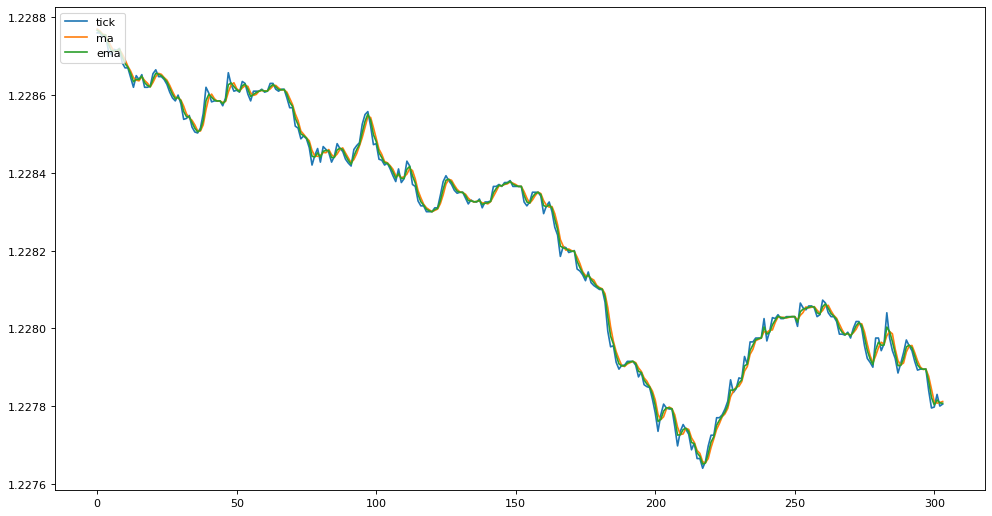

In [14]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data['t'][-len(data['e']):], label = 'tick')
plt.plot(data['m'], label = 'ma')
plt.plot(data['e'], label = 'ema')
plt.legend(loc="upper left")